# Plot object features for different CSLs

In [1]:
from campa.tl import Experiment, FeatureExtractor
from campa.constants import EXPERIMENT_DIR
from campa.pl import hex2rgb, plot_object_stats
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import anndata as ad
import seaborn as sns
import pandas as pd
from copy import deepcopy

In [2]:
exp = Experiment.from_dir('VAE_SBF2/CondVAE_siRNA-CC')
extrs = {data_dir: FeatureExtractor.from_adata(os.path.join(exp.full_path, 'aggregated/full_data', data_dir, 'features_seed3_annotation.h5ad')) 
    for data_dir in exp.data_params['data_dirs'][:-1]}

## explore area vs cajal body intensity

In [6]:
df = pd.concat([extr.adata.uns['object_stats'] for extr in list(extrs.values())], keys=list(extrs.keys()))
df = df.reset_index(level=0)
df = df.reset_index(drop=True)

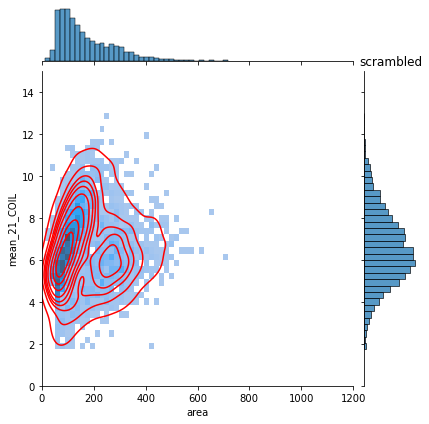

<Figure size 432x288 with 0 Axes>

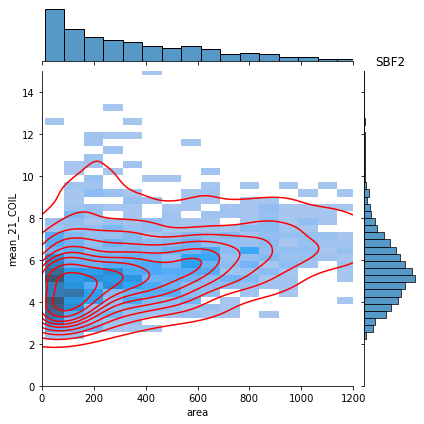

<Figure size 432x288 with 0 Axes>

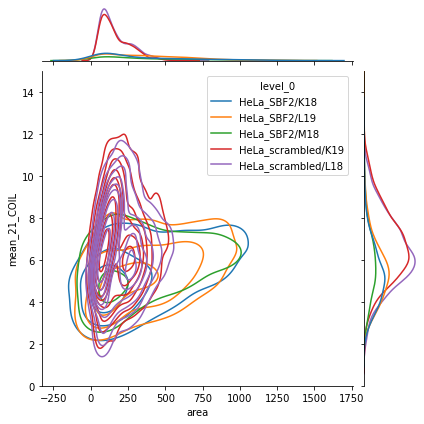

In [12]:
# Cajal bodies intensity vs size
cur_df = df[df['clustering'] == 'Cajal bodies']
# filter those objects with really large area
cur_df = cur_df[cur_df['area'] < np.quantile(cur_df['area'], 0.999)]
# filter ofjects with area < 10
cur_df = cur_df[cur_df['area'] > 10]
# filter objects with low intensity of COIL
cur_df = cur_df[(cur_df['mean_21_COIL'] > 5) | (cur_df['area'] > 50)]


g = sns.jointplot(data=cur_df[cur_df['level_0'].isin(['HeLa_scrambled/L18', 'HeLa_scrambled/K19'])], x="area", y="mean_21_COIL", ylim=[0,15], xlim=[0,1200], kind='hist')
g.plot_joint(sns.kdeplot, color="r")
plt.title('scrambled')
plt.figure()
g = sns.jointplot(data=cur_df[~cur_df['level_0'].isin(['HeLa_scrambled/L18', 'HeLa_scrambled/K19'])], x="area", y="mean_21_COIL", ylim=[0,15], xlim=[0,1200], kind='hist')
g.plot_joint(sns.kdeplot, color="r")
plt.title('SBF2')
plt.figure()
sns.jointplot(data=cur_df, x="area", y="mean_21_COIL", hue='level_0', ylim=[0,15], kind='kde')

## aggregate + plot stats with different filters

In [8]:
# aggregate object statistics
for extr in extrs.values():
    _ = extr.get_object_stats(area_threshold=10, agg=['median'])
# combined adatas for plotting
adata_object_stats_old = ad.concat([extr.adata for extr in extrs.values()], index_unique='-', uns_merge='same')

In [9]:
# get object statistics when filtering cajal bodies with intensity < 3
# aggregate object statistics
for extr in extrs.values():
    old_df = extr.adata.uns['object_stats']
    new_df = deepcopy(old_df[(old_df['mean_21_COIL'] > 5)  | (old_df['area'] > 50) | (old_df['clustering'] != 'Cajal bodies')])
    extr.adata.uns['object_stats'] = new_df
    _ = extr.get_object_stats(area_threshold=10, agg=['median'])
    extr.adata.uns['object_stats'] = old_df
# combined adatas for plotting
adata_object_stats_new = ad.concat([extr.adata for extr in extrs.values()], index_unique='-', uns_merge='same')

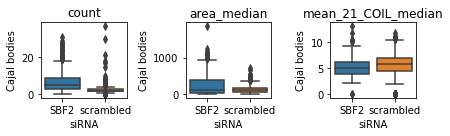

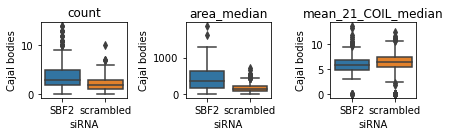

In [11]:
# old: areas < 10 filtered
plot_object_stats(adata_object_stats_old, 'siRNA', features=['count', 'area_median', 'mean_21_COIL_median'], 
                  clusters=['Cajal bodies']) #, 'Nucleolus'])

# new areas < 10 filtered, and small cajal bodies (<=50) with low intensity (<= 5) filteres
plot_object_stats(adata_object_stats_new, 'siRNA', features=['count', 'area_median', 'mean_21_COIL_median'], 
                  clusters=['Cajal bodies'])#, 'Nucleolus'])

In [3]:
# Nucleolus intensity vs size
#df = extr.adata.uns['object_stats']
#df = df[df['clustering'] == 'Nucleolus']
#sns.displot(df, x="area", y="mean_21_NCL")

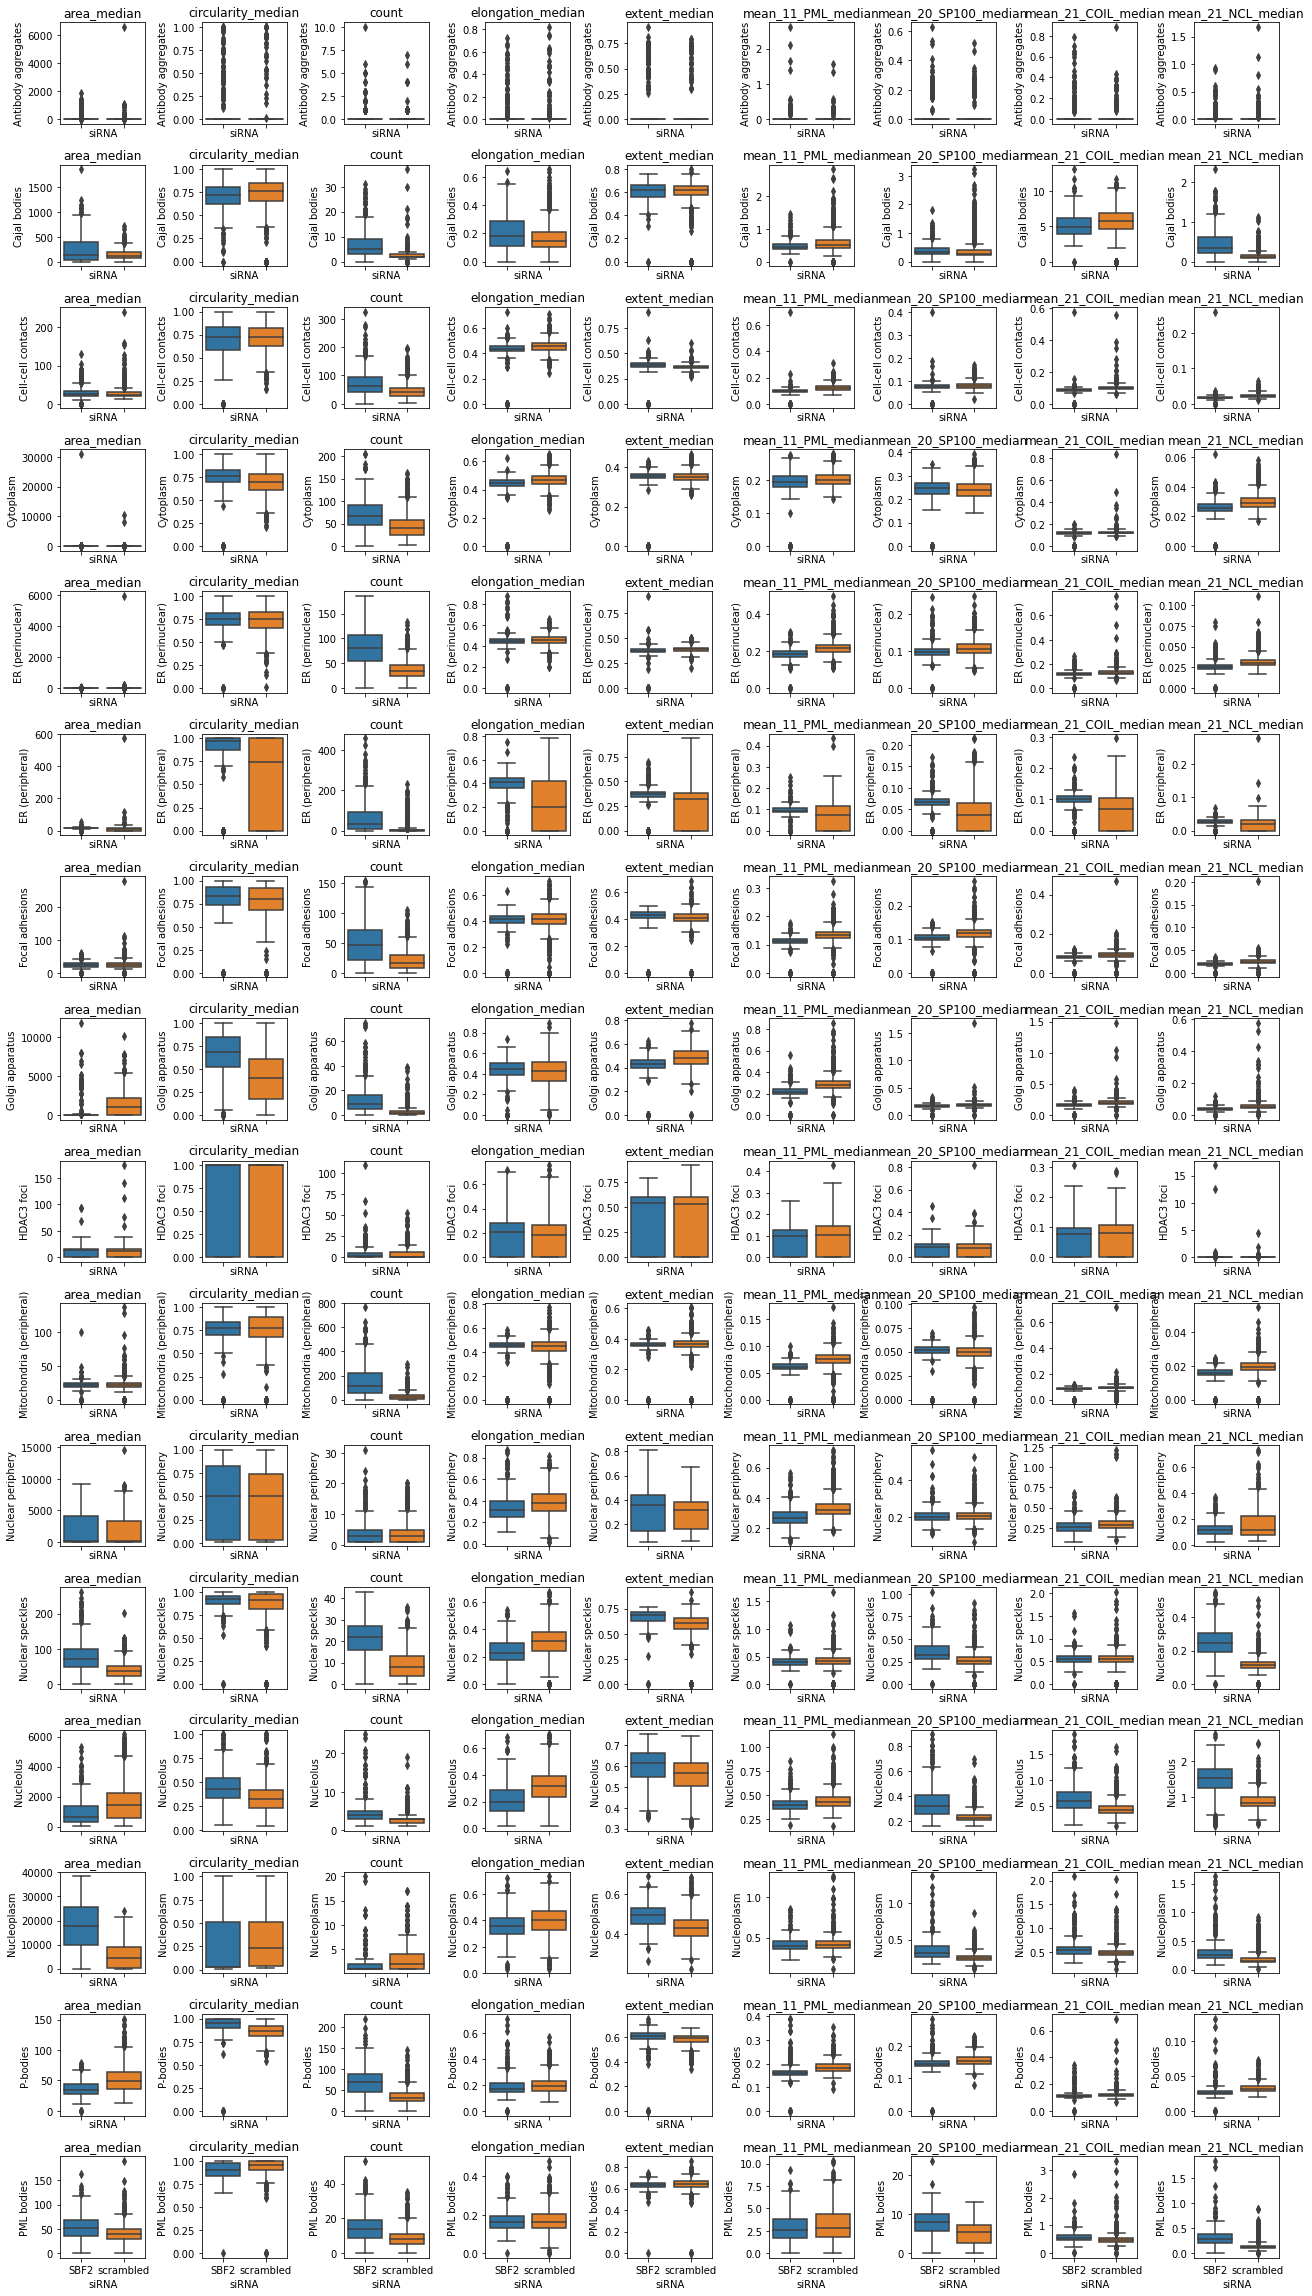

In [142]:
# plot all object stats
plot_object_stats(adata_object_stats_old, 'siRNA')
